<a href="https://colab.research.google.com/github/PamelitaBennett/Python-Twitter-Data-Analysis/blob/main/Development_Notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
%load_ext autoreload

## Setup environment specific requirements and set paths. This is to accommodate
## running from Google Colab or from a local directory

if( os.path.isdir("/content") ):
  # Setup Specific to Google Colab Environment
 
  print("Running from Google Colab Environment")
                  
  !pip install requests
  !pip install requests-oauthlib
  !pip install ratelimit
  
  from google.colab import drive
  drive.mount('/content/drive')
      
  %cd "/content/drive/My Drive/data"

  sourceDirectory = %pwd
  sourceDirectory = sourceDirectory + "/"
  

  # %aimport XXXX
  # from XXXX import *
  
else:
  # Setup Specific to Local Jupyter Environment
  
  print('Running from Local Jupyter Environment')
 
  sourceDirectory = "./"


## Define common  imports here

from pprint import pprint
import json
from datetime import datetime, date

processStartTime = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')

Running from Google Colab Environment
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1I_dpH1UsdsEe51FjqvFpGGykHS0-w-bm/data


#### **Loading the data and libraries that will be used for processing**

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sn
import matplotlib.pyplot as plt
import re
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator




import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet


import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

!python -m spacy download en_core_web_sm
spacyNlpEnCoreWebLg = spacy.load("en_core_web_sm")

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

import random
random_seed = 25
random.seed(random_seed) 

     |████████████████████████████████| 12.0 MB 4.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
path="/content/drive/MyDrive/data/rawdata.json"

with open(path) as data_file:    
    data = json.load(data_file)
    print( len(data['tweets']) )

41047


In [ ]:
data['tweets']

{'1299469396864368640': {'attachments': {'media_keys': ['3_1299469138281275395']},
  'author_id': '407088463',
  'context_annotations': [{'domain': {'description': 'Named people in the world like Nelson Mandela',
     'id': '10',
     'name': 'Person'},
    'entity': {'description': 'Prime Minister of Jamaica Andrew Holness',
     'id': '897375341068525569',
     'name': 'Andrew Holness'}},
   {'domain': {'description': 'Politicians in the world, like Joe Biden',
     'id': '35',
     'name': 'Politician'},
    'entity': {'description': 'Prime Minister of Jamaica Andrew Holness',
     'id': '897375341068525569',
     'name': 'Andrew Holness'}}],
  'conversation_id': '1299469396864368640',
  'created_at': '2020-08-28T22:10:21.000Z',
  'entities': {'annotations': [{'end': 10,
     'normalized_text': '🇯🇲Jamaica',
     'probability': 0.3738,
     'start': 0,
     'type': 'Place'},
    {'end': 52,
     'normalized_text': 'Andrew Holness',
     'probability': 0.9807,
     'start': 39,
     '

In [ ]:
for item in list(data['tweets'].values())[:10]:
  print("{} {} {} {}\n".format(item['id'], item['lang'], item['text'], item['public_metrics']['retweet_count']))

1299469396864368640 en 🇯🇲Jamaica: Latest Poll Shows Drop In Andrew Holness’ Favorability Rating And An Increase In The Unfavorability Rating Of Dr. Peter Phillips.

Details tonight @ 8pm EDT
#JaVotes #PNP #JLP #AndrewHolness #PeterPhillips #Election2020 https://t.co/qKdwXSt3wE 0

1299468770440876039 en @PositiveOrgJA @Nevpositivemeds @chadmorganesq @VPAJamaica @chrisxharper @TijaniChristian @jamie_chevannes @Petchary @MzSammiMiller @shan_dha Voting is a fundamental process in our democratic system. It is a chance for Jamaicans to have a say in the people who representel them!.

#JaVotes2020 3

1299468723535970305 en @vocallywise1 @jlpjamaica They are just wicked and disingenuous 0

1299468577737670658 en @jayjaybrown97 @jlpjamaica They dont have the skillset to reverse it and create anything more plausible 0

1299468212892037120 en @PositiveOrgJA @chadmorganesq @VPAJamaica @chrisxharper @TijaniChristian @jamie_chevannes @Petchary @MzSammiMiller @shan_dha A1. Definitely will be voting, 

#### **Getting the entity of the tweets**

In [ ]:
tweets = data['tweets']
entity =[]
tweetID =[]
for tweet_key, value in tweets.items():
    #print(tweet_key)
  if 'entities' in value.keys():
    if 'annotations' in value['entities'].keys():
      for annotation in value['entities']['annotations']:
        # print(annotation['normalized_text'])
        entity.append(annotation['normalized_text'])
        tweetID.append(value['id'])
    else:
      entity.append("Missing")
      tweetID.append(value['id'])
  else:
      entity.append("Missing")
      tweetID.append(value['id'])

In [ ]:
len(entity)

51580

In [ ]:
len(tweetID)

51580

In [ ]:
entitydf = pd.DataFrame({"Tweet ID":tweetID, "Entity": entity })

In [ ]:
entitydf.head(10)

Tweet ID              Entity
0  1299469396864368640           🇯🇲Jamaica
1  1299469396864368640      Andrew Holness
2  1299469396864368640  Dr. Peter Phillips
3  1299468770440876039             Missing
4  1299468723535970305             Missing
5  1299468577737670658             Missing
6  1299468212892037120             Jamaica
7  1299467893403455491             Missing
8  1299467630315790338             Missing
9  1299467292246446082             Missing

In [ ]:
entitydf.loc[entitydf['Entity']== 'Missing']

Tweet ID   Entity
3      1299468770440876039  Missing
4      1299468723535970305  Missing
5      1299468577737670658  Missing
7      1299467893403455491  Missing
8      1299467630315790338  Missing
...                    ...      ...
51574  1302346275040505856  Missing
51575  1302018465759461378  Missing
51576  1302369542547660802  Missing
51577  1302344226466922496  Missing
51579  1302359485495881736  Missing

[21503 rows x 2 columns]

In [ ]:
teste = set(entity)
len(teste)
print(teste)

{'Damion Mitchell', 'Andrew Michael Holness', '', 'Kam Kam', 'Challenge Andrew', 'Pearnel Sr', 'East Kingston Hot Steppers', 'Cavs', 'Arnaldo', 'new York', 'Virginia USA', 'PaiNP', 'Backroad Truro', 'Ann Fearon', 'dr tufton', 'Unuh', 'NW St Ann', 'Dr\xa0Peter Phillips', 'Laawd PNP', 'Delroy Gary Slowley', 'NIS', 'Jamaica Confederation', 'PNP Politics', 'Jennifer', 'Lord Jesus', 'Central Manchester', 'Parliament One Day', 'Green New Deal', 'Raymond pryce', 'St Andrew East Rural, St Catherine Central', 'Aunty Lisa', 'Jamaica Pnp', 'Dr Wykeham McNeil', 'The Nonpariel Water Supply', 'St. Elizabeth', 'Greater Portmore', 'ST. CATHERINE SOUTH EASTERN', 'Emily Peter', 'fagan', 'West Central St. Andrew', 'DENISE DALEY5', 'Cumberland', 'ARIZONA', 'CLARENDON NORTH CENTRAL', 'Mrs. Holness', 'DiGiCEL', 'Sir Nigel', 'Castro', 'Manleys', 'Television Jamaica', 'JLP Government', 'Shearer', 'RNC', 'National Executive Council', 'Tamara Bailey', 'Mandeville Police', 'Falmouth Town Hall', 'Derval', 'Thar',

In [ ]:
testi = set(tweetID)
len(testi)


41047

In [ ]:
#entitydf.to_excel("Entities.xlsx")

#### **Creating Dataframe with tweets and other relevant data**

In [ ]:
pd.set_option('max_colwidth', 500)     
TweetsDf = pd.DataFrame([(item['id'],item['conversation_id'],item['author_id'], item['text'], item['lang'], item['created_at'], item['public_metrics']['like_count'], item['public_metrics']['reply_count'], item['public_metrics']['retweet_count']) for item in data['tweets'].values()], columns= ["Tweet ID","Conversation ID", "Author ID", "Text", "Lang", "DateOfTweet", "Likes", "Replies", "Retweets"]) 
TweetsDf.shape

(41047, 9)

In [ ]:
TweetsDf.loc[TweetsDf['Tweet ID']== '1299469396864368640']


Tweet ID      Conversation ID  ... Replies Retweets
0  1299469396864368640  1299469396864368640  ...       0        0

[1 rows x 9 columns]

In [ ]:
TweetsDf.head(5)

Tweet ID      Conversation ID  ... Replies Retweets
0  1299469396864368640  1299469396864368640  ...       0        0
1  1299468770440876039  1299467292246446082  ...       0        3
2  1299468723535970305  1299446120402358272  ...       0        0
3  1299468577737670658  1299446120402358272  ...       0        0
4  1299468212892037120  1299467292246446082  ...       0        1

[5 rows x 9 columns]

In [ ]:
TweetsDf.sample(5)

Tweet ID      Conversation ID  ... Replies Retweets
25453  1301615559205949441  1301611534553092096  ...       1        0
38789  1304399616385916928  1304399616385916928  ...       1        1
34175  1299902613400420358  1299902613400420358  ...       0        0
31678  1299911981953101824  1299911981953101824  ...       0        0
21192  1301709175291088897  1301709175291088897  ...       0        2

[5 rows x 9 columns]

#### **Column Type Check**

In [ ]:
TweetsDf.isnull().sum()

Tweet ID           0
Conversation ID    0
Author ID          0
Text               0
Lang               0
DateOfTweet        0
Likes              0
Replies            0
Retweets           0
dtype: int64

In [ ]:
TweetsDf.dtypes

Tweet ID           object
Conversation ID    object
Author ID          object
Text               object
Lang               object
DateOfTweet        object
Likes               int64
Replies             int64
Retweets            int64
dtype: object

In [ ]:
TweetsDf.columns

Index(['Tweet ID', 'Conversation ID', 'Author ID', 'Text', 'Lang',
       'DateOfTweet', 'Likes', 'Replies', 'Retweets'],
      dtype='object')

In [ ]:
TweetsDf.head(5)

Tweet ID      Conversation ID  ... Replies Retweets
0  1299469396864368640  1299469396864368640  ...       0        0
1  1299468770440876039  1299467292246446082  ...       0        3
2  1299468723535970305  1299446120402358272  ...       0        0
3  1299468577737670658  1299446120402358272  ...       0        0
4  1299468212892037120  1299467292246446082  ...       0        1

[5 rows x 9 columns]

##### **Date Column Check**

In [ ]:
from datetime import date
TweetsDf['SendDate']= pd.to_datetime(TweetsDf['DateOfTweet'])


In [ ]:
TweetsDf.drop('DateOfTweet', inplace=True, axis=1)

In [ ]:
TweetsDf.columns

Index(['Tweet ID', 'Conversation ID', 'Author ID', 'Text', 'Lang', 'Likes',
       'Replies', 'Retweets', 'SendDate'],
      dtype='object')

In [ ]:
TweetsDf.head()

Tweet ID      Conversation ID  ... Retweets                  SendDate
0  1299469396864368640  1299469396864368640  ...        0 2020-08-28 22:10:21+00:00
1  1299468770440876039  1299467292246446082  ...        3 2020-08-28 22:07:52+00:00
2  1299468723535970305  1299446120402358272  ...        0 2020-08-28 22:07:41+00:00
3  1299468577737670658  1299446120402358272  ...        0 2020-08-28 22:07:06+00:00
4  1299468212892037120  1299467292246446082  ...        1 2020-08-28 22:05:39+00:00

[5 rows x 9 columns]

###### **Grouping tweets by Date**

In [ ]:
TweetsDF_Grouped_by_date = TweetsDf.groupby([TweetsDf['SendDate'].dt.date])["Text"].count()

In [ ]:
TweetsDF_Grouped_by_date

SendDate
2016-02-01       1
2016-02-26       1
2019-03-08       2
2019-03-09       1
2019-05-09       1
2019-11-11       2
2020-03-14       1
2020-03-17       1
2020-04-07       1
2020-05-18       1
2020-06-15       1
2020-06-16       1
2020-06-28       1
2020-07-02       1
2020-07-08       1
2020-07-11       1
2020-07-15       1
2020-07-17       1
2020-07-18       1
2020-07-21       1
2020-07-27       1
2020-07-28       1
2020-07-29       1
2020-08-06       1
2020-08-08       1
2020-08-09       1
2020-08-11       2
2020-08-12       4
2020-08-13       4
2020-08-14       1
2020-08-15       8
2020-08-16       4
2020-08-17       4
2020-08-18       8
2020-08-19      10
2020-08-20      13
2020-08-21     106
2020-08-22     513
2020-08-23     641
2020-08-24     810
2020-08-25    1117
2020-08-26    7158
2020-08-27     933
2020-08-28    6216
2020-08-29     145
2020-08-30    8523
2020-08-31     578
2020-09-01     638
2020-09-02     759
2020-09-03    3505
2020-09-04    6070
2020-09-05     904
202

Election was announced Aug 11, so we will remove every tweet before Aug 11

In [ ]:
TweetsDf['SendDate2'] = TweetsDf['SendDate'].dt.tz_localize(None)

In [ ]:
TweetsDf['SendDate'] = TweetsDf['SendDate'].dt.tz_localize(None)

In [ ]:
TweetsDf.loc[TweetsDf['SendDate2'] < dt.datetime(2020,8,11)].shape

(28, 10)

In [ ]:
TweetsDf.shape

(41047, 10)

In [ ]:
TweetsDf.drop(TweetsDf[TweetsDf['SendDate2'] < dt.datetime(2020,8,11)].index, inplace=True)


In [ ]:
TweetsDf.shape

(41019, 10)

In [ ]:
TweetsDf.drop('SendDate2', inplace=True, axis=1)

In [ ]:
TweetsDf.shape

(41019, 9)

##### **Lang Column check**

In [ ]:
TweetsDf['Lang'].value_counts()

en     37995
und     1680
in       356
tl       245
es       163
fr       104
ht        90
nl        50
et        45
ca        34
pt        32
cy        30
de        22
ro        21
it        19
da        17
pl        15
sv        14
ja        12
tr        11
no         8
hi         7
eu         7
lt         7
ur         6
lv         6
hu         5
vi         5
cs         4
fi         4
is         2
ta         1
sl         1
zh         1
Name: Lang, dtype: int64

##### **Adding a column to the dataframe to identify patois tweets by using bootstraing**

In [ ]:
@interact
def find_specific_instances(keywords=r"\bnah\b|\bunuh\b|\benuh\b|\bdeh\b|\bnuh\b|\bwid\b|\binno\b|\bwi\b|\bmi\b|\bfi\b|\bdem\b|\bboi\b|\bguh\b|\bnyam\b|bcah\b|\bweh\b"):
    samplepatoisTweetsDf = TweetsDf.loc[TweetsDf["Text"].str.contains(keywords, na=False, case=False) ]
    
    #print(samplepatoisTweetsDf.shape )
    #return samplepatoisTweetsDf.sample(n=10, random_state=random_seed)
    return samplepatoisTweetsDf
patoisTweetsDf = find_specific_instances(keywords=r"\bnah\b|\bunuh\b|\benuh\b|\bdeh\b|\bnuh\b|\bwid\b|\binno\b|\bwi\b|\bmi\b|\bfi\b|\bdem\b|\bboi\b|\bguh\b|\bnyam\b|bcah\b|\bweh\b")


interactive(children=(Text(value='\\bnah\\b|\\bunuh\\b|\\benuh\\b|\\bdeh\\b|\\bnuh\\b|\\bwid\\b|\\binno\\b|\\b…

In [ ]:
TweetsDf['isPatois'] = False
TweetsDf.loc[TweetsDf["Tweet ID"].isin(patoisTweetsDf["Tweet ID"]), "isPatois" ] = True

In [ ]:
patoisTweetsDf.shape[0]/TweetsDf.shape[0] #Percentage of patois tweets

0.10648723762159

In [ ]:
TweetsDf.sample(10)

Tweet ID      Conversation ID  ...            SendDate isPatois
23008  1301691019143118849  1301691019143118849  ... 2020-09-04 01:18:17    False
36829  1299895021563523073  1299895021563523073  ... 2020-08-30 02:21:38    False
27310  1301492538583535616  1301492538583535616  ... 2020-09-03 12:09:36    False
28797  1300878340639928320  1300877990436499456  ... 2020-09-01 19:29:00    False
24691  1301664100116844544  1301664100116844544  ... 2020-09-03 23:31:19    False
9475   1298461640220868608  1298461640220868608  ... 2020-08-26 03:25:53    False
18698  1301955450582302720  1301955450582302720  ... 2020-09-04 18:49:03    False
1483   1299187459234897921  1299187459234897921  ... 2020-08-28 03:30:02     True
12368  1298450443094437894  1298450443094437894  ... 2020-08-26 02:41:24     True
34786  1299900107488473088  1299900107488473088  ... 2020-08-30 02:41:51    False

[10 rows x 10 columns]

##### **Examining numeric columns- Likes, Replies and Retweets**

In [ ]:
TweetsDf.describe()

Likes       Replies      Retweets
count   41019.000000  41019.000000  41019.000000
mean       61.130110      3.831541     15.476462
std      2351.647669    232.974089    598.812923
min         0.000000      0.000000      0.000000
25%         0.000000      0.000000      0.000000
50%         1.000000      0.000000      0.000000
75%         3.000000      1.000000      1.000000
max    255177.000000  37669.000000  53704.000000

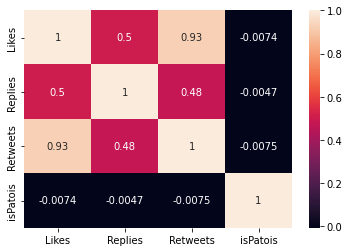

In [ ]:
corrMatrix = TweetsDf.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

#####  **Text Column check**

In [ ]:
TweetsDf.Text.unique().shape

(40901,)

Of the 41,019 tweets. 40,901 are unique.

#### **Word Count**

In [ ]:
all_words = [word for tokens in TweetsDf['Text'] for word in tokens]# Comparing this with Sherice options
tweet_lengths = [len(tokens) for tokens in TweetsDf['Text']]
vocab = sorted(list(set(all_words)))

print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_lengths)))

5129020 words total, with a vocabulary size of 948
Max tweet length is 717


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


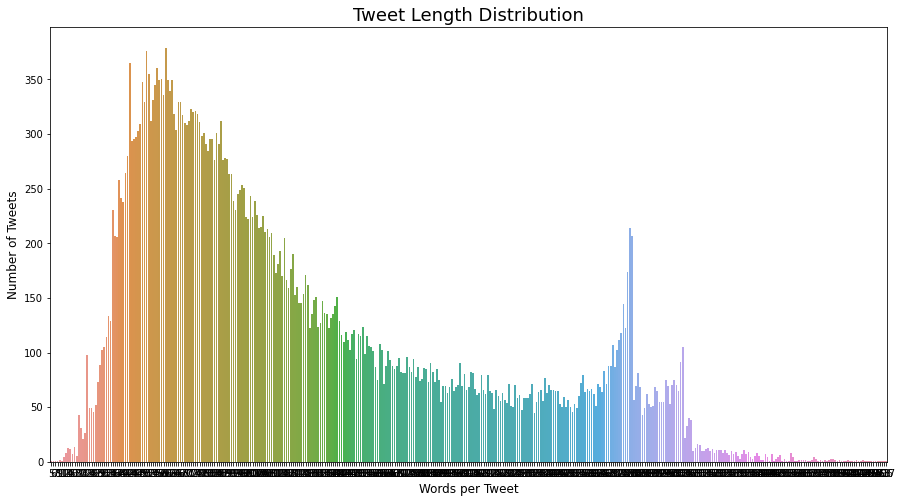

In [ ]:
plt.figure(figsize = (15,8))
sn.countplot(tweet_lengths)
plt.title('Tweet Length Distribution', fontsize = 18)
plt.xlabel('Words per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()

In [ ]:
# print(len(data['tweets']['1304885770524688387']['text']))
# print(len(data['tweets']['1304885770524688387']['text'].split()))


texts = []
word_count = []
for i in data['tweets']:
    if 'text' in list(data['tweets'][i].keys()):
      word_count = word_count + [len(data['tweets'][i]['text'].split())]

      texts = texts + [data['tweets'][i]['text']]
      #print(data['users'][i]['location'])
#print(texts)
#print(word_count)


In [ ]:
Tweet_length = set(word_count)
Tweet_length # the length of the tweets

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 66,
 68,
 69,
 72,
 73,
 74,
 88}

**Examining the mentions made to determine most popular mentions**

In [ ]:
def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  


<input>:3: DeprecationWarning: invalid escape sequence \s
<ipython-input-49-66fbd4931c02>:3: DeprecationWarning: invalid escape sequence \s
  return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)


In [ ]:
TweetsDf['mentioned'] = TweetsDf.Text.apply(find_mentioned)


In [ ]:
TweetsDf

Tweet ID  ...                                                                                                                                                 mentioned
0      1299469396864368640  ...                                                                                                                                                        []
1      1299468770440876039  ...  [@PositiveOrgJA, @Nevpositivemeds, @chadmorganesq, @VPAJamaica, @chrisxharper, @TijaniChristian, @jamie_chevannes, @Petchary, @MzSammiMiller, @shan_dha]
2      1299468723535970305  ...                                                                                                                              [@vocallywise1, @jlpjamaica]
3      1299468577737670658  ...                                                                                                                             [@jayjaybrown97, @jlpjamaica]
4      1299468212892037120  ...                    [@PositiveOrgJA, @chadmorganesq, @VPAJamaica, @chrisxharper, @TijaniChristian, @jamie_chevannes, @Petchary, @MzSammiMiller, @shan_dha]
...                    ...  ...                                                                                                                                                       ...
41042  1302018465759461378  ...                                                                                                                                                        []
41043  1302369542547660802  ...                                                                                                                                            [@kxng_geniuz]
41044  1302344226466922496  ...                                                                  [@Owen05437732, @UncleBarry876, @judzlanimac, @sweetjarose, @ChrisPinnock1, @jlpjamaica]
41045  1302353277837889537  ...                                                                             [@DavidMc75880030, @tinkabell608, @maryserb17, @DrPeterPhillips, @JamaicaPNP]
41046  1302359485495881736  ...                                                                                                               [@joseblackwoody, @darylvazmp, @JamaicaPNP]

[41019 rows x 11 columns]

We will now examine the most popular hashtags 

In [ ]:
mentionsDf= TweetsDf.loc[TweetsDf.mentioned.apply(lambda mentions_list: mentions_list !=[] ),['mentioned']]
mentionsDf.head()

mentioned
1  [@PositiveOrgJA, @Nevpositivemeds, @chadmorganesq, @VPAJamaica, @chrisxharper, @TijaniChristian, @jamie_chevannes, @Petchary, @MzSammiMiller, @shan_dha]
2                                                                                                                              [@vocallywise1, @jlpjamaica]
3                                                                                                                             [@jayjaybrown97, @jlpjamaica]
4                    [@PositiveOrgJA, @chadmorganesq, @VPAJamaica, @chrisxharper, @TijaniChristian, @jamie_chevannes, @Petchary, @MzSammiMiller, @shan_dha]
6                                                                                                                              [@JAProsperity, @jlpjamaica]

We will now put each mention in a seperate row

In [ ]:
mentionsDf2 = pd.DataFrame([mention for mentions_list in mentionsDf.mentioned for mention in mentions_list],columns=['mentioned'])

In [ ]:
sortedMentionCount = mentionsDf2.groupby('mentioned').size().reset_index(name='counts').sort_values('counts', ascending=False).reset_index(drop=True)

Now we can view the most popular mentions

In [ ]:
sortedMentionCount.head()

mentioned  counts
0       @JamaicaPNP    5462
1       @jlpjamaica    4850
2  @AndrewHolnessJM    1949
3   @JamaicaGleaner    1508
4  @DrPeterPhillips    1137

In [ ]:
TweetsDf.to_excel("Tweets.xlsx")

In [ ]:
TweetsDf.head()

Tweet ID  ...                                                                                                                                                 mentioned
0  1299469396864368640  ...                                                                                                                                                        []
1  1299468770440876039  ...  [@PositiveOrgJA, @Nevpositivemeds, @chadmorganesq, @VPAJamaica, @chrisxharper, @TijaniChristian, @jamie_chevannes, @Petchary, @MzSammiMiller, @shan_dha]
2  1299468723535970305  ...                                                                                                                              [@vocallywise1, @jlpjamaica]
3  1299468577737670658  ...                                                                                                                             [@jayjaybrown97, @jlpjamaica]
4  1299468212892037120  ...                    [@PositiveOrgJA, @chadmorganesq, @VPAJamaica, @chrisxharper, @TijaniChristian, @jamie_chevannes, @Petchary, @MzSammiMiller, @shan_dha]

[5 rows x 11 columns]

### **Topic Modelling**

#### **Clean up Tweets**

In [ ]:
def cleanText(text):
    regexMention = r'\B\@([\w\-]+)'
    regexUrl = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
    regexHashTag = r'\B(\#[a-zA-Z0-9]+\b)(?!;)'

    text = re.sub(regexMention,'', text)
    text = re.sub(regexUrl,'', text)
    text = re.sub(regexHashTag,'', text)
    
    return text

In [ ]:
cleanData = TweetsDf.copy()

cleanData['Text'] = cleanData['Text'].apply(cleanText)

In [ ]:
cleanData.head()

Tweet ID  ...                                                                                                                                                 mentioned
0  1299469396864368640  ...                                                                                                                                                        []
1  1299468770440876039  ...  [@PositiveOrgJA, @Nevpositivemeds, @chadmorganesq, @VPAJamaica, @chrisxharper, @TijaniChristian, @jamie_chevannes, @Petchary, @MzSammiMiller, @shan_dha]
2  1299468723535970305  ...                                                                                                                              [@vocallywise1, @jlpjamaica]
3  1299468577737670658  ...                                                                                                                             [@jayjaybrown97, @jlpjamaica]
4  1299468212892037120  ...                    [@PositiveOrgJA, @chadmorganesq, @VPAJamaica, @chrisxharper, @TijaniChristian, @jamie_chevannes, @Petchary, @MzSammiMiller, @shan_dha]

[5 rows x 11 columns]

#### **Preprocessing**

In [ ]:
nlp= spacy.load("en")

# My list of stop words.
#stop_list = ['🇲']

# Updates spaCy's default stop words list with my additional words. 
#nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [ ]:
def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.
nlp.add_pipe(lemmatizer,name='lemmatizer', after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

In [ ]:
doc_list = []
# Iterates through each article in the corpus.
for doc in tqdm(cleanData.Text):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc, disable=["tok2vec", "tagger", "parser", "attribute_ruler"])
    doc_list.append(pr)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/41019 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

In [ ]:
#Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

#### Modellling

In [ ]:
lda_model = LdaModel(corpus=corpus,
                      id2word=words,
                      num_topics=10, 
                      random_state=random_seed,
                      update_every=1,
                      passes=10,
                      alpha='auto',
                      per_word_topics=True
                     )

lda_model.show_topics()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

[(0,
  '0.079*"  " + 0.032*"Jamaica" + 0.024*" " + 0.023*"PNP" + 0.022*"\n\n " + 0.021*"   " + 0.019*"election" + 0.019*"vote" + 0.016*"JLP" + 0.015*"    "'),
 (1,
  '0.022*"Election" + 0.021*"woman" + 0.020*"2020" + 0.019*"|" + 0.018*"Minister" + 0.016*"3" + 0.016*"Prime" + 0.012*"🤔" + 0.012*"General" + 0.012*"count"'),
 (2,
  '0.035*"️" + 0.013*"thank" + 0.013*"statement" + 0.013*"👀" + 0.012*"green" + 0.012*"=" + 0.011*"box" + 0.011*"future" + 0.010*"♂" + 0.009*"🤷"'),
 (3,
  '0.156*"\n " + 0.027*"💚" + 0.025*"🔔" + 0.022*"✌" + 0.010*"Ann" + 0.009*"🙄" + 0.009*"station" + 0.007*"de" + 0.007*"swear" + 0.005*"❎"'),
 (4,
  '0.080*"Andrew" + 0.070*"Peter" + 0.057*"🤣" + 0.056*"Phillips" + 0.036*"Holness" + 0.028*"Dionne" + 0.026*"🇲" + 0.026*"🇯" + 0.017*"Dr." + 0.016*"🏾"'),
 (5,
  '0.106*"😂" + 0.058*"debate" + 0.033*"tonight" + 0.012*"watch" + 0.012*"mask" + 0.012*"winner" + 0.010*"tie" + 0.009*"💀" + 0.009*"House" + 0.008*"Rohan"'),
 (6,
  '0.086*"question" + 0.039*"answer" + 0.028*"ask" + 0.0

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, words)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.419699  0.054950       1        1  43.890834
7      0.108431 -0.316584       2        1   9.069983
1      0.056068  0.177296       3        1   7.949798
4     -0.049623  0.222706       4        1   6.894149
9     -0.097867 -0.043352       5        1   5.964468
3     -0.098000  0.019892       6        1   5.684402
5     -0.087155 -0.048258       7        1   5.666344
6     -0.087187 -0.027245       8        1   5.569208
8     -0.092055 -0.033011       9        1   5.209853
2     -0.072310 -0.006394      10        1   4.100961, topic_info=            Term          Freq         Total Category  logprob  loglift
83                13851.000000  13851.000000  Default  30.0000  30.0000
67           \n    3553.000000   3553.000000  Default  29.0000  29.0000
1051           😂   2399.000000   2399.000000  Default  28.0000  28.0000
3         Andrew   2203.000000   2203.000000  Default  27.0000  27.0000
795     question   1921.000000   1921.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
4581       steal     84.769533     85.571038  Topic10  -5.2662   3.1845
2488          🏽‍     82.639028     83.440265  Topic10  -5.2916   3.1843
600         news     78.324984     79.126363  Topic10  -5.3452   3.1838
711   commitment     76.313887     77.115360  Topic10  -5.3713   3.1835
1731           U     79.119154    178.809000  Topic10  -5.3352   2.3786

[369 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
662       2  0.999427    \n
23        1  0.954989  \n\n
23        2  0.017218  \n\n
23        4  0.001230  \n\n
23       10  0.025827  \n\n
...     ...       ...   ...
498       4  0.994231     🙏
830       3  0.998645     🤔
476       4  0.999351     🤣
2515     10  0.994019     🤦
457      10  0.996716     🤷

[393 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 2, 5, 10, 4, 6, 7, 9, 3])

#### **Evaluating model**

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_list, dictionary=words, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt


Perplexity:  -8.071613960811568

Coherence Score:  0.41702776038933703


The model have a perplexity of -8.07161396103847 and a coherence score of  0.41702776038933703. This can be improved by changing hyperparameters such as topic count

**Most popular words**

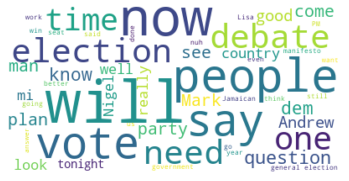

In [ ]:

%matplotlib inline

text = " ".join( cleanText(t) for t in TweetsDf.Text)


sw= set(STOPWORDS)
sw.update(["Jamaica","PNP","JLP","amp"])
wc= WordCloud(stopwords=sw,max_font_size=70, max_words=50,background_color="white").generate(text) #selecting the  top 100 words
plt.figure()
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.show()

